# Metadata annotation

Publically availble metadata can help contexualize an in-house experiment. Pertpy allows metadata to be easily fetched and perturbations to be annotated, augmenting existing datasets to increase sample sizes for training of machine learning models and add prior knowledge.

A couple of databases can be queried, which we categorize by the type of metadata:

- Cell line metadata：
  - Cancer Dependency Map (DepMap) at Broad
  - Genomics of Drug Sensitivity in Cancer (GDSC)
- Genomic datasets:
  - DepMap at Broad: Gene expression data
  - DepMap at Sanger: Gene expression and protein intensity values
- Cell line x perturbation interactions:
  - Genomics of Drug Sensitivity in Cancer (GDSC): Drug sensitivity

This notebook demonstrates how you can use pertpy metadata with two examples:

1. Sanity check of private data with publically available cell line expression profiles
2. Analysis of cell-line specific IC50-related genes using the GDSC database


In [1]:
import random
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import anndata as ad
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

Let's use the dataset from the original MIX-Seq paper ([McFarland et al., 2020](https://www.nature.com/articles/s41467-020-17440-w)), a scRNA-seq dataset of 99 cell lines and 13 different drugs. We subset it to 50000 cells to speed up the run time.


In [2]:
adata = pt.dt.mcfarland_2020()

In [3]:
adata

AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [4]:
sc.pp.filter_genes(adata, min_cells=30)
sc.pp.normalize_total(adata)
sc.pp.subsample(adata, n_obs=50000, random_state=42)

## Cell line metadata


`annotate` uses a column in `.obs` called `DepMap_ID` as identifiers and adds metadata columns to `.obs`. We only annotate using 3 metadata columns here, but you can see the full set of available metadata using `lookup.cell_line_meta`.

Data is downloaded to the directory for cache files used by scanpy (Defaults to `cache`).


In [5]:
cl_metadata = pt.md.CellLine()
cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    fetch=["CellLineName", "Age", "OncotreePrimaryDisease", "SangerModelID"],
)

AnnData object with n_obs × n_vars = 50000 × 25031
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'SangerModelID'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'

Annotated metadata is saved as additional columns in `adata.obs`.


In [6]:
adata.obs.iloc[:, 36:]

,CellLineName,Age,OncotreePrimaryDisease,SangerModelID
TTATGCTAGTGATCGG,NCI-H1581,44.0,Non-Small Cell Lung Cancer,SIDM00748
AGCGTCGTCTCGGACG,SNU-1105,61.0,Diffuse Glioma,NaN
TTGGGTACATTGCTTT,SK-MEL-3,42.0,Melanoma,SIDM01105
TACTTGTTCAGCGACC,786-O,58.0,Renal Cell Carcinoma,SIDM00125
CACAGTATCGGCTACG,COLO-680N,57.0,Esophageal Squamous Cell Carcinoma,SIDM00956
...,...,...,...,...
TGCCCTACATGAGCGA,KYSE-270,79.0,Esophageal Squamous Cell Carcinoma,SIDM01029
CTGATCCGTATGTCAC,BT-474,60.0,Invasive Breast Carcinoma,SIDM00963
TATTACCAGCAGACTG,NCI-H460,NaN,Non-Small Cell Lung Cancer,SIDM00144
TGTGGTATCTCCAGGG,SK-MEL-3,42.0,Melanoma,SIDM01105


We can check the number of overlapping cell lines using `lookup`.


In [7]:
lookup = cl_metadata.lookup()
lookup.available_cell_lines(
    query_id_list=adata.obs.cell_line.unique(), reference_id="CellLineName"
)

173 cell lines are not found in the metadata.

36 cell lines are found!

Hmmm, it looks like there isn't much overlap with existing databases using the cell line names. However, there is complete overlap when mapping using DepMap_ID! This is due a slight inconsistency in using dashes in cell line names, so try to use a unique ID as much as possible.


In [8]:
lookup.available_cell_lines(
    query_id_list=adata.obs.DepMap_ID.unique(), reference_id="ModelID"
)

0 cell lines are not found in the metadata.

209 cell lines are found!

One question we might have after sequencing an in vitro experiment is "How similar are our expression profiles compared to the public database?" To answer this, we generate "pseudobulks" by aggregating counts to the cell-type level and then compare them with bulk RNA-seq data.


In [9]:
ps = pt.tl.PseudobulkSpace()
# Calculate the pseudobulks
pdata = ps.compute(adata, target_col="CellLineName", groups_col="perturbation")

/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/decoupler/utils_anndata.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cols = obs.groupby([sample_col, groups_col]).apply(lambda x: x.apply(lambda y: len(y.unique()) == 1)).all(0)
/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [10]:
# Extract the base line expression
base_line = pdata[pdata.obs.perturbation == "control"]
base_line.obs.index = base_line.obs.index.str.replace("_control", "")

In [11]:
lookup.available_bulk_rna(
    query_id_list=adata.obs.DepMap_ID.unique(), cell_line_source="broad"
)

1 cell lines are not found in the metadata.

208 cell lines are found!

We annotate bulk RNA expression data from the Broad Institute because it contains more overlapping cell lines with the McFarland dataset.


In [12]:
cl_metadata.annotate_bulk_rna(base_line, cell_line_source="broad", query_id="DepMap_ID")

To annotate bulk RNA data from Broad Institue,  `DepMap_ID` is used as default reference and query identifier if no
`reference_id` is given.  Ensure that `DepMap_ID` is available in 'adata.obs'.  Alternatively, use `annotate()` to 
annotate the cell line first

[bold blue]There are 155 identifiers in `adata.obs`.However, 1 identifiers can't be found in the bulk RNA annotation,leading to the presence of NA values for their respective metadata.

- Please check again: 
- ACH-000047
- ...


/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/pertpy/metadata/_cell_line.py:471: ImplicitModificationWarning: Setting element `.obsm['bulk_rna_broad']` of view, initializing view as actual.
  adata.obsm["bulk_rna_broad"] = ccle_expression


AnnData object with n_obs × n_vars = 155 × 25031
    obs: 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'SangerModelID', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    obsm: 'bulk_rna_broad'
    layers: 'psbulk_props'

The bulk RNA expression data is stored in `adata.obsm[bulk_rna_broad]`


In [13]:
base_line.obsm["bulk_rna_broad"]

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
22Rv1,2.179511,0.0,6.316146,3.407353,4.642702,0.014355,0.124328,5.816088,7.045814,5.057017,...,0.000000,0.000000,0.000000,0.028569,0.250962,0.432959,3.875780,0.137504,0.0,0.000000
253J-BV,3.942045,0.0,5.967169,1.883621,3.581351,0.000000,0.084064,5.087463,4.444932,3.794936,...,0.000000,0.201634,0.124328,0.000000,0.150560,0.526069,4.526069,0.214125,0.0,0.000000
42-MG-BA,3.880686,0.0,6.733083,1.922198,3.390943,0.028569,0.575312,5.816856,3.313246,3.903038,...,0.028569,0.000000,0.042644,0.014355,0.070389,0.555816,2.601697,0.000000,0.0,0.084064
5637,5.128871,0.0,6.691534,2.010780,4.976364,0.163499,1.636915,6.193575,3.505891,3.709291,...,0.000000,0.000000,0.150560,0.028569,0.014355,0.298658,2.978196,0.000000,0.0,0.000000
639-V,4.328406,0.0,7.058749,1.891419,3.529821,0.000000,3.878725,6.432792,4.698774,4.912650,...,0.028569,0.201634,0.028569,0.056584,0.189034,0.505891,3.820690,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEN,4.418190,0.0,7.247453,2.134221,3.841973,0.000000,0.070389,6.435795,3.740928,4.249445,...,0.000000,0.000000,0.084064,0.014355,0.226509,0.389567,4.275752,0.070389,0.0,0.000000
TUHR4TKB,4.309613,0.0,7.265849,2.042644,3.553361,0.097611,5.257765,6.048105,4.058316,3.539779,...,0.000000,0.000000,0.000000,0.000000,0.014355,0.411426,4.647315,0.000000,0.0,0.000000
UACC-257,4.134221,0.0,6.318498,2.042644,4.228049,0.042644,0.176323,5.866908,4.586164,4.361066,...,0.000000,0.000000,0.286881,0.028569,0.111031,0.632268,5.216843,0.000000,0.0,0.000000
UM-UC-1,5.683416,0.0,7.125155,1.963474,2.523562,0.028569,2.969012,5.472488,4.869378,3.543496,...,0.000000,0.000000,0.000000,0.189034,0.000000,0.731183,2.587365,0.000000,0.0,0.000000


In [14]:
# Subset and sort overlapping genes
overlapping_genes = set(base_line.var.ensembl_id) & set(
    base_line.obsm["bulk_rna_broad"].columns
)
base_line = base_line[:, base_line.var["ensembl_id"].isin(overlapping_genes)]
base_line.obsm["bulk_rna_broad"] = base_line.obsm["bulk_rna_broad"][
    base_line.var.ensembl_id
]

/var/folders/zz/rylc5nzn5bzd41ydv9q1q7tm0000gn/T/ipykernel_82725/2526010814.py:6: ImplicitModificationWarning: Setting element `.obsm['bulk_rna_broad']` of view, initializing view as actual.
  base_line.obsm["bulk_rna_broad"] = base_line.obsm["bulk_rna_broad"][


In [15]:
# Log normalize the counts
sc.pp.log1p(base_line)
# Correlate the pseudobulks with the bulk RNA-seq data
# corr and pvals: correlation and p-value df for the overlapping cell lines
# unmatched_cl_orr and unmatched_cl_pvals: correlation and p-value df for cell lines that are only present in McFarland dataset
corr, pvals, unmatched_cl_corr, unmatched_cl_pvals = cl_metadata.correlate(
    base_line, identifier="DepMap_ID", metadata_key="bulk_rna_broad"
)

Column name of metadata is not the same as the index of adata.var. Ensure that the genes are in the same order.

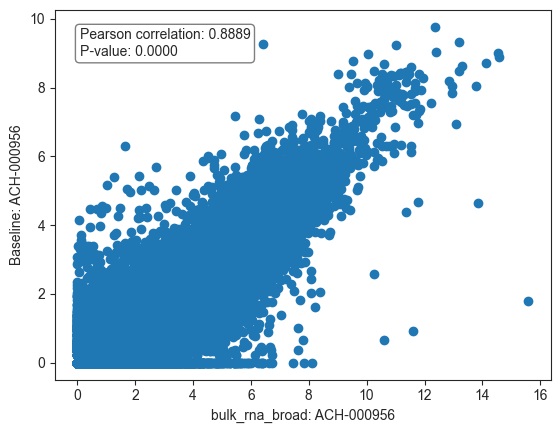

In [16]:
# Visualize the correlation of cell lines by scatter plot
cl_metadata.plot_correlation(
    base_line,
    corr=corr,
    pval=pvals,
    identifier="DepMap_ID",
    metadata_key="bulk_rna_broad",
    subset_identifier=0,  # gain insights of individual cell lines instead of the global statistics
    # 0 means the first id is chosen
)

We observe a high correlation between the baseline gene expression in the McFarland dataset and the bulk RNA-seq expression data from the Broad Institute, suggesting good concordance between these two sources. We can also visualize the correlation matrix via heatmap.


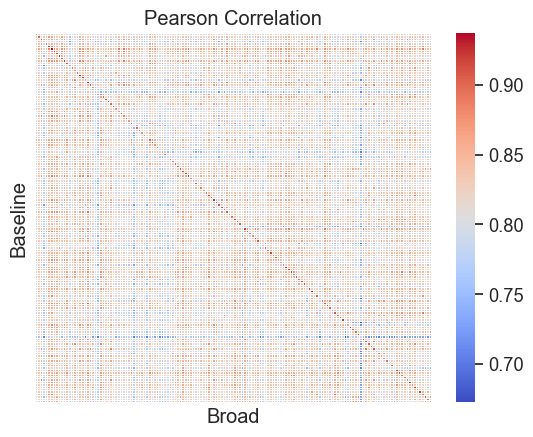

In [17]:
# Generally a cell line is most correlated with itself
sns.set(font_scale=1.2)
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,
    linewidths=0.7,
    xticklabels=False,
    yticklabels=False,
)
plt.title("Pearson Correlation")
plt.xlabel("Broad")
plt.ylabel("Baseline")
plt.show()

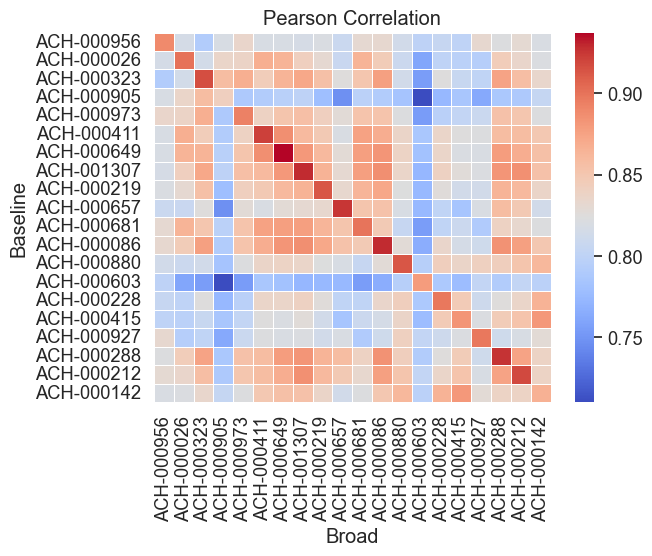

In [18]:
# Subset to first 20 cell lines
sns.heatmap(
    corr.iloc[:20, :20], cmap="coolwarm", annot=False, linewidths=0.7, yticklabels=True
)
plt.title("Pearson Correlation")
plt.xlabel("Broad")
plt.ylabel("Baseline")
plt.show()

The cell line ACH-000047 is the only cell line here that is not listed in the Broad database. Among all evaluated cell lines, it demonstrates the highest baseline gene expression correlation with the cell line ACH-000842 from the database.


In [19]:
unmatched_cl_max_corr = pd.concat(
    # find the highest correlation and the corresponding cell line
    [unmatched_cl_corr.idxmax(axis=1), unmatched_cl_corr.max(axis=1)],
    # create a dataframe with one column for the cell line identifier, and one column for the correlation value
    axis=1,
    keys=["cell_line", "correlation"],
)
unmatched_cl_max_corr

,cell_line,correlation
DepMap_ID,,
ACH-000047,ACH-000900,0.876248


In [20]:
# Compare the tissue type of two cell lines.
base_line[base_line.obs["DepMap_ID"].isin(["ACH-000047", "ACH-000842"])].obs[
    ["singlet_ID", "disease"]
]

,singlet_ID,disease
GCIY,GCIY_STOMACH,gastric cancer
SW 480,SW480_LARGE_INTESTINE,colon/colorectal cancer


## IC50-related genes using the GDSC database


Post-treatment differential expression data can offer valuable insights into understanding the relationship between gene expression and drug responses. To demonstrate how pertpy can be used to model perturbation responses, a linear regression model can be trained to associate the single-cell transcriptional profiles measured in each cell line to their viability effects in the drug sensitivity data from GDSC.


Cell line-specific drug sensitivity data can be retrieved from the GDSC database, which will be saved as a single column `ln_ic50` in `obs`.


In [21]:
lookup.available_drug_response(
    reference_id="cell_line_name", query_id_list=pdata.obs.CellLineName.unique()
)

85 cell lines are not found in the metadata.

108 cell lines are found!

In [22]:
lookup.available_drug_response(
    reference_id="sanger_model_id", query_id_list=pdata.obs.SangerModelID.unique()
)

30 cell lines are not found in the metadata.

130 cell lines are found!

In [23]:
# Annotate with sanger model ids because it has more matches
cl_metadata.annotate_from_gdsc(
    pdata, reference_id="sanger_model_id", query_id="SangerModelID", gdsc_dataset=1
)

[bold blue]There are 160 identifiers in `adata.obs`.However, 30 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.

- Please check again: 
- SIDM00605
- SIDM00011
- SIDM00165
- SIDM01241
- SIDM00162
- ...


AnnData object with n_obs × n_vars = 1109 × 25031
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'psbulk_n_cells', 'psbulk_counts', 'ln_ic50'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    layers: 'psbulk_props'

In [24]:
pdata[~pdata.obs.ln_ic50.isna()].obs[
    ["CellLineName", "SangerModelID", "perturbation", "ln_ic50"]
]

,CellLineName,SangerModelID,perturbation,ln_ic50
index,,,,
639-V_Afatinib,639-V,SIDM00999,Afatinib,0.830291
8505C_Afatinib,8505C,SIDM00996,Afatinib,4.756863
A549_Afatinib,A549,SIDM00903,Afatinib,0.825679
CAL-29_Afatinib,CAL-29,SIDM00936,Afatinib,-0.580518
COLO 829_Afatinib,COLO 829,SIDM00909,Afatinib,2.282764
...,...,...,...,...
SUIT-2_Trametinib,SUIT-2,SIDM00371,Trametinib,-4.544078
SW48_Trametinib,SW48,SIDM00837,Trametinib,-2.957706
TE-11_Trametinib,TE-11,SIDM00348,Trametinib,0.017331


In [25]:
sc.pp.log1p(pdata)
sc.pp.highly_variable_genes(
    pdata,
    n_top_genes=4000,
    subset=True,
)
# Subtract mean of the control from the perturbation, grouped by cell lines.
pdata.layers["counts"] = pdata.X.copy()
ps.compute_control_diff(
    pdata, target_col="perturbation", group_col="DepMap_ID", layer_key="counts"
)

/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


AnnData object with n_obs × n_vars = 1109 × 4000
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'psbulk_n_cells', 'psbulk_counts', 'ln_ic50'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'psbulk_props', 'counts', 'control_diff'

In [26]:
# Remove the missing values
pdata = pdata[pdata.obs.perturbation != "control"]
pdata = pdata[~pdata.obs.ln_ic50.isna()]
pdata

View of AnnData object with n_obs × n_vars = 300 × 4000
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'psbulk_n_cells', 'psbulk_counts', 'ln_ic50'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'psbulk_props', 'counts', 'control_diff'

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    pdata.layers["control_diff"], pdata.obs.ln_ic50, test_size=0.2, random_state=0
)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

Mean squared error: 3.87
Coefficient of determination: 0.58


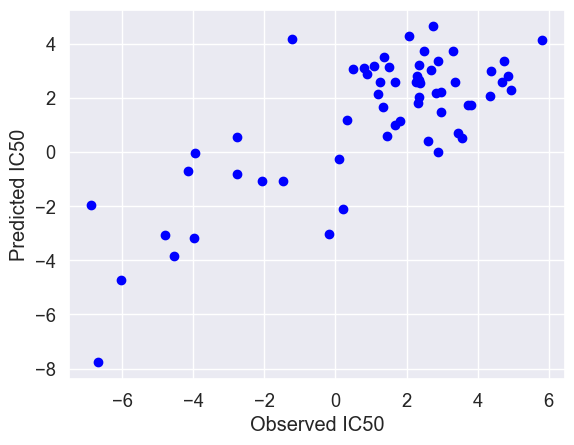

In [28]:
print(f"Mean squared error: {mean_squared_error(y_test, y_predict):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_predict):.2f}")
plt.scatter(y_test, y_predict, color="blue")
plt.xlabel("Observed IC50")
plt.ylabel("Predicted IC50")
plt.show()

The scatter plot shows the actual IC50 values along the x-axis and the IC50 values predicted by the linear regression model along the y-axis. Feature selection might improve the model performance since the dataset contains the 32738 genes.

We group the 99 McFarland cell lines with similar drug response across different perturbation conditions.


In [29]:
# Convert the metadata from long-format structure to wide-format.
drug_response = cl_metadata.drug_response_gdsc1[
    cl_metadata.drug_response_gdsc1["sanger_model_id"].isin(adata.obs.SangerModelID)
].pivot(index="sanger_model_id", columns="drug_name", values="ln_ic50")
drug_response

drug_name,(5Z)-7-Oxozeaenol,5-Fluorouracil,965-D2,993-D2,A-443654,A-770041,A-83-01,ACY-1215,AGI-6780,AICA Ribonucleotide,...,ZG-10,ZL049,ZL109,ZM447439,ZSTK474,Zibotentan,"eEF2K Inhibitor, A-484954",kb NB 142-70,rTRAIL,torin2
sanger_model_id,,,,,,,,,,,,,,,,,,,,,
SIDM00078,NaN,5.118639,NaN,NaN,NaN,NaN,3.652131,2.668564,1.109762,NaN,...,NaN,NaN,NaN,NaN,2.261426,5.650162,5.599792,2.648226,NaN,NaN
SIDM00082,-1.563812,4.658563,2.334063,5.789613,-0.150852,3.532823,2.906650,-0.212638,1.899654,8.206035,...,0.612734,2.321447,-1.944659,2.214653,0.767857,5.568706,4.728700,1.397482,-3.153947,-2.830939
SIDM00084,1.262660,3.925992,3.940645,2.438440,NaN,NaN,4.812808,2.714968,1.900023,10.017972,...,2.311749,3.118459,0.209324,1.305183,0.693133,5.512840,5.565186,3.212475,-4.662101,-3.634064
SIDM00088,1.908030,2.600372,3.908177,5.096741,NaN,NaN,5.679359,1.625163,2.289905,5.920128,...,NaN,3.280589,-0.592856,1.699848,-0.330501,6.060386,5.937943,2.127663,-0.768015,NaN
SIDM00095,0.841369,3.679005,4.449700,4.115001,-2.132005,-0.976091,4.364168,3.031034,2.572742,7.809407,...,0.881948,4.013678,-0.182599,3.679702,2.300400,5.997767,6.348844,2.639928,0.856078,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM01137,1.320095,5.066861,NaN,NaN,NaN,NaN,3.187351,2.874190,1.940443,7.609840,...,NaN,5.302856,1.943636,4.937148,2.888459,6.306783,6.374921,2.622249,NaN,NaN
SIDM01147,3.100242,7.053073,NaN,NaN,NaN,NaN,3.997404,3.195092,2.060407,7.742121,...,1.271105,4.687243,0.692827,4.002567,1.990412,6.143921,6.930870,4.321953,0.237040,-1.779067
SIDM01150,1.341786,2.810680,1.979444,4.782687,NaN,NaN,4.707861,5.530318,1.509492,7.642328,...,NaN,3.384139,-0.148229,2.165370,1.767269,5.699568,5.751098,5.747831,-1.470564,NaN


We'll fill in the missing values with 0 for now so that we can achieve a clustering:


In [30]:
adata_drug_reponse = ad.AnnData(drug_response.fillna(0))
adata_drug_reponse

AnnData object with n_obs × n_vars = 140 × 378

/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


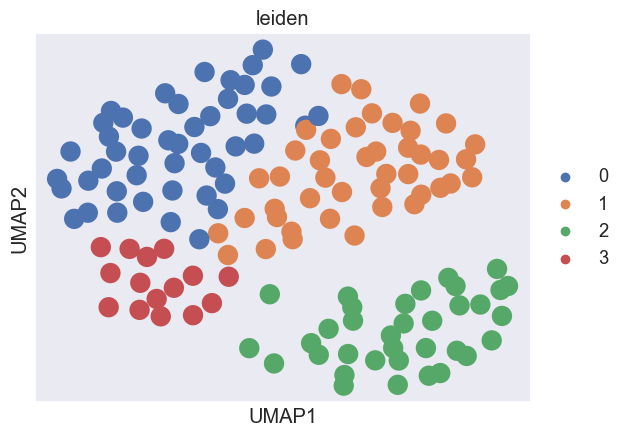

In [31]:
sc.pp.pca(adata_drug_reponse)
sc.pp.neighbors(adata_drug_reponse)
sc.tl.umap(adata_drug_reponse)
sc.tl.leiden(adata_drug_reponse, resolution=0.5, key_added="leiden")
sc.pl.umap(adata_drug_reponse, color="leiden")
# Label the cell lines
adata_drug_reponse.obs["SangerModelID"] = adata_drug_reponse.obs.index
pdata.obs = pdata.obs.merge(adata_drug_reponse.obs, how="left")

To visualize the clustering, cell lines are embedded into a UMAP embedding. The cell lines in the McFarland dataset are clustered into 7 groups in terms of gene–drug associations.


In [32]:
# Sort coefficients of the overlapping genes in decreasing order
coeff = pd.DataFrame({"coefficients": lr.coef_}, index=pdata.var_names).sort_values(
    by="coefficients", ascending=False
)
coeff

,coefficients
MT-ND6,0.099030
NUP37,0.088699
PPP1R9A,0.085843
KRT81,0.080835
CPNE7,0.075700
...,...
RASD1,-0.076661
NTN4,-0.081617
C15orf48,-0.085004
TMEM40,-0.103041


Afatinib


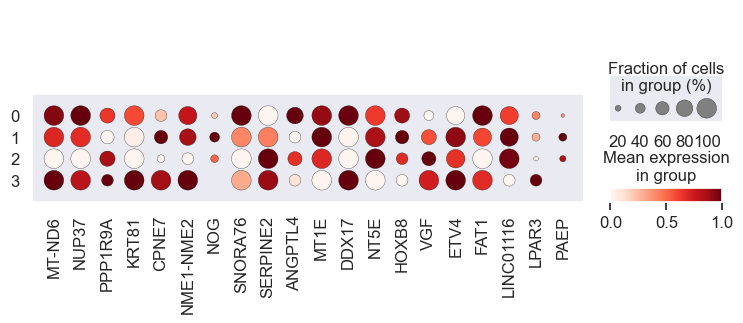

Bortezomib


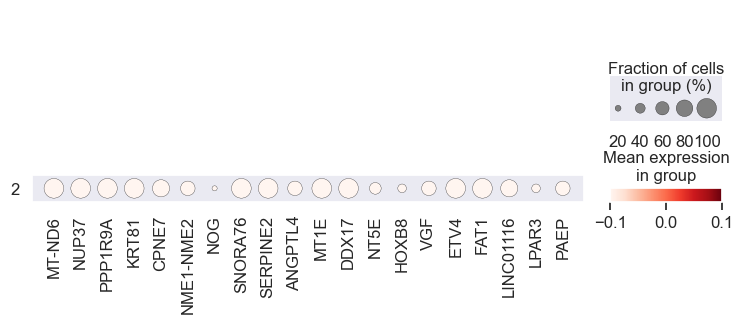

Dabrafenib


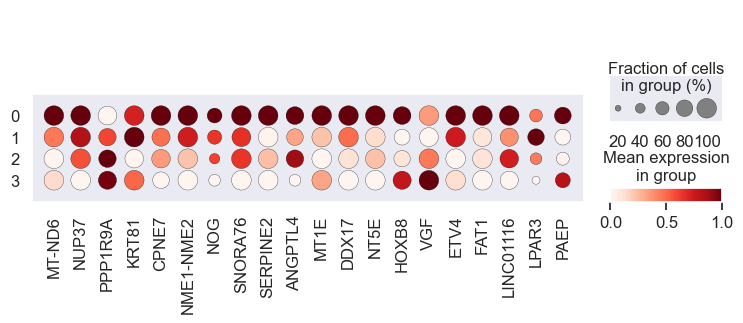

Gemcitabine


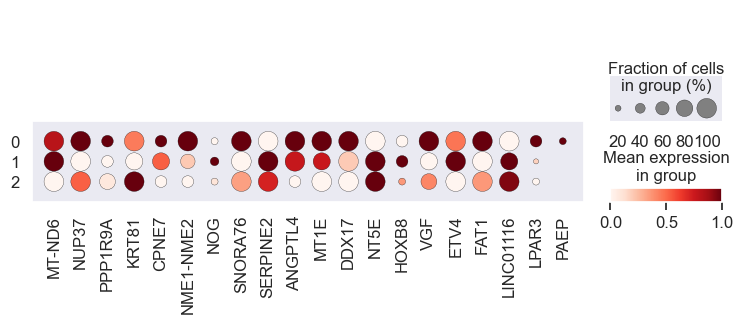

JQ1


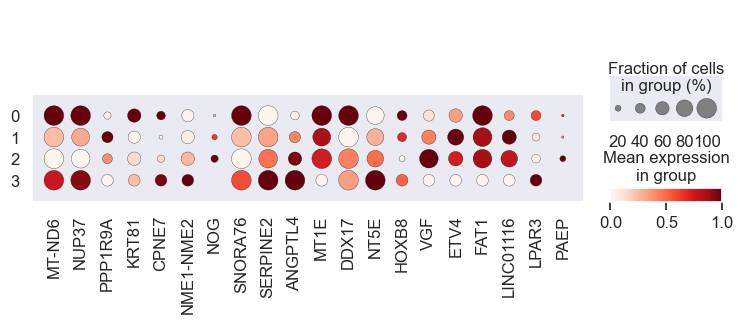

Navitoclax


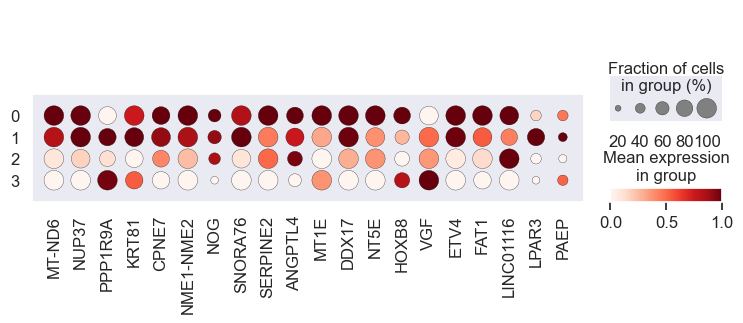

Trametinib


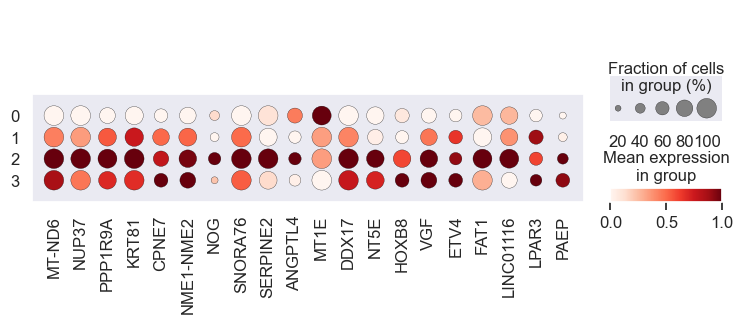

In [35]:
# Visualize gene expression for different perturbation separately
# Cell lines within a group should have a similar response to a specific perturbation
for pert in pdata.obs.perturbation.unique():
    print(pert)
    sc.pl.dotplot(
        pdata[pdata.obs.perturbation == pert],
        var_names=coeff.index.values[0:20],
        groupby="leiden",
        standard_scale="var",
    )

We observe that the gene expression pattern is similar within each cell line set but vary across any two sets. This implies that genes with high absolute coefficient values have a greater impact on drug response.
